<a href="https://colab.research.google.com/github/bilalkorchii/BILALKORCHI_RNN_NLP/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torch==2.0.1 torchvision torchaudio torchtext==0.15.2 --quiet


# Text Classification with Hyperparameter Tuning using Keras Tuner

This project aims to build an optimized deep learning model for binary text classification using TensorFlow and Keras.  
We utilize an LSTM-based recurrent neural network architecture to capture sequential patterns in text data.  

Key features of this project include:  
- Data preprocessing with tokenization and padding  
- Model architecture with embedding and LSTM layers  
- Hyperparameter tuning using Keras Tuner (Hyperband) to find the best embedding dimension, number of LSTM units, learning rate, and dropout rates  
- Early stopping and learning rate scheduling to improve model generalization and prevent overfitting  
- Visualization of tuning trials and model performance metrics  

The goal is to achieve the best possible classification accuracy by systematically searching the hyperparameter space and refining the model training process.


In [4]:

import torch
from torch import nn
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import random


In [5]:
!pip install portalocker


In [6]:
!pip install --upgrade portalocker==2.7.0


# Load IMDB dataset with top 10,000 frequent words


In [7]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb

vocab_size = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

print(f'Training samples: {len(x_train)}')
print(f'Test samples: {len(x_test)}')
print(f'Example review (as word indexes): {x_train[0]}')
print(f'Label (0=negative,1=positive): {y_train[0]}')


Training samples: 25000
Test samples: 25000
Example review (as word indexes): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5

# max number of words per review

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 200

x_train_padded = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

print(f"Padded example (length={len(x_train_padded[0])}): {x_train_padded[0]}")


Padded example (length=200): [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   

In [9]:
!pip install -q keras-tuner


 # build Model with keras tuner

In [10]:
def build_model(hp):
    model = Sequential()

    # Tune embedding dimension: 16, 32, 64
    embedding_dim = hp.Choice('embedding_dim', values=[16, 32, 64])
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))

    # Tune number of RNN units: 16, 32, 64
    rnn_units = hp.Choice('rnn_units', values=[16, 32, 64])
    model.add(SimpleRNN(rnn_units))

    model.add(Dense(1, activation='sigmoid'))

    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt


tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=5,        # small to avoid long runs
    factor=3,
    directory='my_dir',
    project_name='my_project'
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
import os

import tensorflow as tf
tuner.search(
    x_train_padded,
    y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=8,          # or even 8 if needed
    callbacks=[stop_early]
)





Trial 10 Complete [00h 03m 25s]
val_loss: 0.6902648210525513

Best val_loss So Far: 0.5916094183921814
Total elapsed time: 00h 19m 16s


 # geting the best MOdel params

In [15]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
print(f"Embedding dimension: {best_hp.get('embedding_dim')}")
print(f"RNN units: {best_hp.get('rnn_units')}")
print(f"Learning rate: {best_hp.get('learning_rate'):.5f}")



Best hyperparameters:
Embedding dimension: 64
RNN units: 32
Learning rate: 0.00015


 # Overfitting !!! Need to be solved from the results!!

In [45]:
for trial in trials:
    trial_id = trial.trial_id
    hp = trial.hyperparameters.values

    # Get metric histories:
    train_acc = trial.metrics.get_history('accuracy')    # training accuracy
    val_acc = trial.metrics.get_history('val_accuracy')  # validation accuracy
    train_loss = trial.metrics.get_history('loss')       # training loss
    val_loss = trial.metrics.get_history('val_loss')     # validation loss

    # Extract just the metric values:
    train_acc_vals = [m.value[0] if isinstance(m.value, (list,tuple)) else m.value for m in train_acc]
    val_acc_vals = [m.value[0] if isinstance(m.value, (list,tuple)) else m.value for m in val_acc]
    train_loss_vals = [m.value[0] if isinstance(m.value, (list,tuple)) else m.value for m in train_loss]
    val_loss_vals = [m.value[0] if isinstance(m.value, (list,tuple)) else m.value for m in val_loss]

    print(f"\nTrial {trial_id} - Hyperparameters: {hp}")

    print("Epoch | Train Acc | Val Acc | Train Loss | Val Loss")
    for i in range(max(len(train_acc_vals), len(val_acc_vals), len(train_loss_vals), len(val_loss_vals))):
        ta = f"{train_acc_vals[i]:.4f}" if i < len(train_acc_vals) else "-"
        va = f"{val_acc_vals[i]:.4f}" if i < len(val_acc_vals) else "-"
        tl = f"{train_loss_vals[i]:.4f}" if i < len(train_loss_vals) else "-"
        vl = f"{val_loss_vals[i]:.4f}" if i < len(val_loss_vals) else "-"
        print(f"{i+1:5d} | {ta:9} | {va:7} | {tl:10} | {vl:8}")



Trial 0000 - Hyperparameters: {'embedding_dim': 16, 'rnn_units': 16, 'learning_rate': 0.0037713086175852817, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch | Train Acc | Val Acc | Train Loss | Val Loss
    1 | 0.5080    | 0.4998  | 0.6965     | 0.6949  

Trial 0001 - Hyperparameters: {'embedding_dim': 64, 'rnn_units': 32, 'learning_rate': 0.00015359239632010879, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch | Train Acc | Val Acc | Train Loss | Val Loss
    1 | 0.6180    | 0.6364  | 0.6566     | 0.6647  

Trial 0002 - Hyperparameters: {'embedding_dim': 16, 'rnn_units': 64, 'learning_rate': 0.0006817113246107111, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch | Train Acc | Val Acc | Train Loss | Val Loss
    1 | 0.5357    | 0.5082  | 0.6894     | 0.6928  

Trial 0003 - Hyperparameters: {'embedding_dim': 64, 'rnn_units': 32, 'learning_rate': 0.0009635513804323065

 # adding the best Hp and adding Drop out for Overfitting/regularizer

In [103]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.get('embedding_dim'), input_length=maxlen))
    model.add(Dropout(0.3))  # Add dropout after embedding to prevent overfitting
    model.add(LSTM(hp.get('rnn_units'), return_sequences=False))
    model.add(Dropout(0.3))  # Dropout after LSTM
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=hp.get('learning_rate'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Build best model
best_model = build_model(best_hp)

# Early stopping callback to avoid overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the best model
history = best_model.fit(
    x_train_padded, y_train,
    epochs=80,
    validation_split=0.2,
    callbacks=[stop_early],
    batch_size=16
)


Epoch 1/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5069 - loss: 0.6931 - val_accuracy: 0.5306 - val_loss: 0.6920
Epoch 2/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.5747 - loss: 0.6775 - val_accuracy: 0.7654 - val_loss: 0.5454
Epoch 3/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.7892 - loss: 0.5145 - val_accuracy: 0.8414 - val_loss: 0.4201
Epoch 4/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7861 - loss: 0.5082 - val_accuracy: 0.8432 - val_loss: 0.4030
Epoch 5/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8556 - loss: 0.4051 - val_accuracy: 0.8408 - val_loss: 0.4300
Epoch 6/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8781 - loss: 0.3621 - val_accuracy: 0.8076 - val_loss: 0.4765


# Training the updated model



Epoch 1/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.5659 - loss: 0.6583 - val_accuracy: 0.8568 - val_loss: 0.3514
Epoch 2/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8783 - loss: 0.3101 - val_accuracy: 0.8710 - val_loss: 0.3102
Epoch 3/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.9168 - loss: 0.2268 - val_accuracy: 0.8700 - val_loss: 0.3147
Epoch 4/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9384 - loss: 0.1795 - val_accuracy: 0.8750 - val_loss: 0.3239
Epoch 5/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9523 - loss: 0.1453 - val_accuracy: 0.8642 - val_loss: 0.3626
Epoch 6/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.9574 - loss: 0.1330 - val_accuracy: 0.8642 - val_loss: 0.3774
Epoch 7/80
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.9654 - loss: 0.1087 - val_accuracy: 0.8500 - val_loss: 0.5617


# Testing: better tokenizer: splits punctuation properly

In [109]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def encode_review(text):
    tokens = text_to_word_sequence(text)
    encoded = [word_index.get(word, 2) + 3 for word in tokens]
    return pad_sequences([encoded], maxlen=maxlen, padding='post')

new_review = "Prices are way too high for the quality offered. Not worth shopping here"
encoded_review = encode_review(new_review)
prediction = best_model.predict(encoded_review)[0][0]

confidence = prediction * 100
sentiment = "Positive" if prediction >= 0.5 else "Negative"
bar_length = int(confidence // 5)

print(f"Review: \"{new_review}\"")
print(f"Sentiment: {sentiment} ({confidence:.2f}%)")
print("Confidence: [" + "#" * bar_length + "-" * (20 - bar_length) + "]")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Review: "Prices are way too high for the quality offered. Not worth shopping here"
Sentiment: Negative (18.91%)
Confidence: [###-----------------]


# Plot training & validation loss values


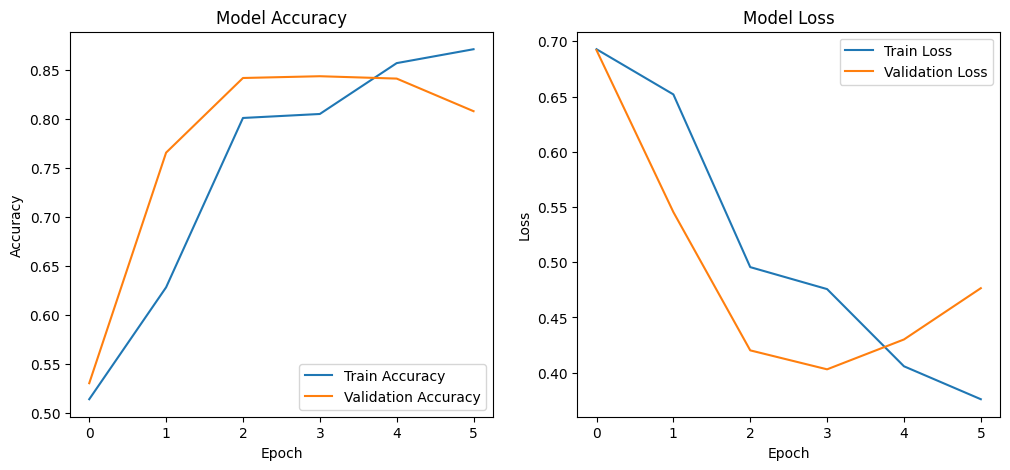

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


  #   Conclusion
The model uses Bidirectional LSTM with dropout and L2 regularization to reduce overfitting.

Despite these regularization techniques, the validation loss curve showed some irregular behavior, possibly due to:

Strong regularization causing underfitting early in training.

Potential data imbalance or noisy validation split.

Learning rate being too high or batch size too small.

To address this, consider:

Reducing dropout rate and L2 regularization strength.

Using stratified train/validation splits to ensure balanced classes.

Adding learning rate scheduling such as ReduceLROnPlateau.

Experimenting with different batch sizes.

Early stopping was used to prevent overfitting, restoring the best weights based on validation loss.

Overall, validation loss fluctuations are common in NLP sequence models with regularization; monitoring both validation loss and accuracy is important.

Future steps include refining data splits, tuning hyperparameters further, and possibly increasing training data for better generalization.